In [1]:
from dotenv import load_dotenv
from tqdm.notebook import trange, tqdm 
from tqdm.asyncio import tqdm_asyncio
from semantic_kernel import Kernel
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion, OpenAIChatPromptExecutionSettings, AzureTextEmbedding
from semantic_kernel.connectors.ai.chat_completion_client_base import ChatCompletionClientBase
from semantic_kernel.contents import ChatHistory 
from semantic_kernel.core_plugins.text_memory_plugin import TextMemoryPlugin
from semantic_kernel.memory.semantic_text_memory import ( MemoryQueryResult,
    SemanticTextMemory,
)
from semantic_kernel.connectors.memory.azure_cosmosdb_no_sql import AzureCosmosDBNoSQLMemoryStore
from azure.cosmos.aio import ContainerProxy, CosmosClient, DatabaseProxy

import os
import extract_msg
import pandas as pd
import csv
from datetime import datetime
import json
import multiprocessing
import concurrent.futures
import time
import asyncio
import nest_asyncio

nest_asyncio.apply()

# Load environment variables from .env file
load_dotenv()
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_CHAT_DEPLOYMENT_NAME = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
COSMOS_CONNECTION_STRING = os.getenv("COSMOS_CONNECTION_STRING")
COSMOS_DATABASE = os.getenv("COSMOS_DATABASE_NAME")
COSMOS_COLLECTION = os.getenv("COSMOS_COLLECTION_NAME")
EMAIL_EXCEL = "TestData\\TestData.xlsx"
EMAIL_EXCEL_EMBEDDINGS = "TestData\\TestData_Embeddings.xlsx"
SHEET_NAME_EMAIL = "Dataset_Email#2&TT"
MSG_DATA_FOLDER_PATH = "D:\\git\\MailDispatcher\\TestData"
MSG_TEST_FOLDER = "TestData"
MSG_TESTRESULT_FOLDER = "TestResults"
DEBUG = True
INIT_DATA = False
print(AZURE_OPENAI_ENDPOINT)
print(AZURE_OPENAI_CHAT_DEPLOYMENT_NAME)
print(COSMOS_DATABASE)


https://openaipamontagsweden.openai.azure.com/
gpt4o
maildispatcherdb


Prompt Collection

In [14]:
PROMPT_AI="""
Sei un esperto smistatore di ticket a partire dal testo di una mail che deve analizzarne il suo contenuto e capire a quale gruppo di supporto inviare il ticket. 
Riceverai in input:
- il testo di una mail
- il titolo della mail

In base al suo contenuto dovrai restituire solo e soltanto la categoria alla quale ridirezionare il ticket. Le categorie a disposizione sono le seguenti:
- SWITCH
- RESET PASSWORD SAP
- SIGS WEB
- UNKNOWN

Scegli:
- SWITCH se il contenuto o il titolo della mail hanno riferimenti ad una procedura di normalizzazione o abilitazione di apparati di rete o switch. 
In dettaglio può richiedere il supporto per la modifica della sua installazione o configurazione, la risoluzione di problemi di connettività,
la risoluzione di problemi di routing, la risoluzione di problemi di accesso ai servizi di rete
- RESET PASSWORD SAP se il contenuto o il titolo della mail hanno riferimenti alla richiesta della modifica di una password da parte di un utente o il suo reset. 
- SIGS WEB se il contenuto o il titolo della mail hanno riferimenti a problemi relativi all'applicazione SIGSWEB o SIGSI o suo sinonimo come ad esempio problemi di accesso,
 di performance, di visualizzazione e/o di caricamento.
- UNKNOWN se non riesci a capire a quale gruppo di supporto inviare il ticket

Devi restituire l'output in formato json che include la mail a cui ridirezionare il ticket nel campo mailToTestResult e il motivo della scelta nel campo reasoning che non DEVE includere virgole o altri caratteri che non siano alfanumerici. NON INCLUDERE ALTRO TESTO ALL'INFUORI DELLA MAIL.
L'output che devi restituire DEVE essere sempre un JSON con questi campi:
{
  ""mailToTestResult"": ""<mail a cui ridirezionare il ticket>""
  ""reasoning"": ""<motivazione della scelta>""
}

Di seguito le informazioni su cui eseguire le analisi:
"""

PROMPT_EMBEDDING="""
Sei un esperto smistatore di ticket a partire dal testo di una mail che deve analizzarne il suo contenuto e capire a quale gruppo di supporto inviare il ticket. 
Riceverai in input:
- il testo di una mail
- il titolo della mail

In base al suo contenuto dovrai restituire solo e soltanto la categoria alla quale ridirezionare il ticket. Le categorie a disposizione sono le seguenti:
- SWITCH
- RESET PASSWORD SAP
- SIGSWEB
- UNKNOWN

Scegli:
- SWITCH se il contenuto o il titolo della mail hanno riferimenti ad una procedura di normalizzazione o abilitazione di apparati di rete o switch. 
In dettaglio può richiedere il supporto per la modifica della sua installazione o configurazione, la risoluzione di problemi di connettività,
la risoluzione di problemi di routing, la risoluzione di problemi di accesso ai servizi di rete
- RESET PASSWORD SAP se il contenuto o il titolo della mail hanno riferimenti alla richiesta della modifica di una password da parte di un utente o il suo reset. 
- SIGSWEB se il contenuto o il titolo della mail hanno riferimenti a problemi relativi all'applicazione SIGSWEB o SIGSI o suo sinonimo come ad esempio problemi di accesso,
 di performance, di visualizzazione e/o di caricamento.
- UNKNOWN se non riesci a capire a quale gruppo di supporto inviare il ticket

Devi restituire l'output in formato json che include la mail a cui ridirezionare il ticket nel campo mailToTestResult e il motivo della scelta nel campo reasoning che non DEVE includere virgole o altri caratteri che non siano alfanumerici. NON INCLUDERE ALTRO TESTO ALL'INFUORI DELLA MAIL.
L'output che devi restituire DEVE essere sempre un JSON con questi campi:
{
  ""mailToTestResult"": ""<mail a cui ridirezionare il ticket>""
  ""reasoning"": ""<motivazione della scelta>""
}

In aggiunta ti verrà fornito il risultato di una ricerca vettoriale di similarità e puoi aiutarti con quella per scegliere la mail a cui ridirezionare il ticket.

Di seguito le informazioni su cui eseguire le analisi:
"""


Define common functions

In [3]:
# Define functions
def list_files_with_extension(folder, extension):
    return [f for f in os.listdir(folder) if f.endswith(extension)]

def load_msgs(folder_name):
    file_collection = []
    files = list_files_with_extension(folder_name, ".msg")

    # Iterate over each file
    for file_name in files:
        #debug("Processing msg: ", file_name)
        file_path = os.path.join(folder_name, file_name)   
        with extract_msg.openMsg(file_path) as msg:
            file_collection.append({"filename": f"{file_name}", "msgid": f"{msg.messageId}", "sender": f"{msg.sender}", "to": f"{msg.to}", "subject": f"{msg.subject}", "body": f"{msg.body}", "htmlbody": f"{msg.htmlBody}"})   
    return file_collection

def debug(message):
    if(DEBUG):
        print(message)
    



Initalize SemanticKernel 

In [4]:
chat_completion_service = AzureChatCompletion()
embedding_service = AzureTextEmbedding(service_id="text_embedding")   

# Initialize the kernel
kernel = Kernel()

# Add the chat completion service created above to the kernel
kernel.add_service(chat_completion_service)
kernel.add_service(embedding_service)

# Retrieve the chat completion service by type
chat_completion_service = kernel.get_service(type=ChatCompletionClientBase)
execution_settings = OpenAIChatPromptExecutionSettings(temperature=0, maxtokens=1000)
# memory store
#https://github.com/microsoft/semantic-kernel/blob/main/python/samples/concepts/memory/memory.py
cosmosclient = CosmosClient.from_connection_string(COSMOS_CONNECTION_STRING)
indexing_policy = {
    "vectorIndexes": [
        {
            "path": "/embedding",
            "type": "diskANN",
            "quantizationByteSize": 96,
            "indexingSearchListSize": 100
        }
    ]
}
vector_embedding_policy = { 
    "vectorEmbeddings": [ 
        { 
            "path": "/embedding", 
            "dataType": "float32", 
            "distanceFunction": "cosine", 
            "dimensions": 1536 
        }
    ]    
}
cosmos_container_properties = {
      "partition_key": "/key"
}
noSqlMemoryStore = AzureCosmosDBNoSQLMemoryStore(cosmosclient, COSMOS_DATABASE, "/key", vector_embedding_policy, indexing_policy, cosmos_container_properties )
await noSqlMemoryStore.create_collection(COSMOS_COLLECTION)
collectionname = await noSqlMemoryStore.does_collection_exist(COSMOS_COLLECTION)
print(f"Collection {COSMOS_COLLECTION} is present: {collectionname}")
memory = SemanticTextMemory(storage=noSqlMemoryStore, embeddings_generator=kernel.get_service("text_embedding"))

async def get_correct_mail_from_msg(msg):
    start = time.time()
    chat_history = ChatHistory()
    prompt = f"""{PROMPT_AI}
    Titolo della mail: {msg.Oggetto}
    Contenuto della mail: {msg.Messaggio}"""

    chat_history.add_user_message(prompt)

    response = await chat_completion_service.get_chat_message_content(
        chat_history=chat_history,
        settings=execution_settings
    )
    end = time.time()
    debug(f"Execution time for {msg.Oggetto}: {(end-start) * 10**3} ms")
    debug(f"Token consumption for {msg.Oggetto} - PromptTokens: {response.metadata["usage"].prompt_tokens} CompletionTokens: {response.metadata["usage"].completion_tokens}")
    return response 

async def get_embeddings(msg):
    start = time.time()
    embeddings = await memory.search(COSMOS_COLLECTION, f"{msg.subject} {msg.body}", limit=3)
    end = time.time()
    debug(f"Execution time for {msg.Oggetto}: {(end-start) * 10**3} ms")
    return embeddings

async def get_correct_mail_with_embeddings_from_msg(msg, embeddings):
    start = time.time()
    chat_history = ChatHistory()
    prompt = f"""{PROMPT_AI}
    Titolo della mail: {msg.Oggetto}
    Contenuto della mail: {msg.Messaggio}

    E il risultato della ricerca vettoriale:""" 
    for results in embeddings:
        prompt = f"{prompt} \n {results.description} - {results.relevance}" 
    #debug(f"Prompt: {prompt}")
    chat_history.add_user_message(prompt)

    response = await chat_completion_service.get_chat_message_content(
        chat_history=chat_history,
        settings=execution_settings
    )
    end = time.time()
    debug(f"Execution time for {msg.Oggetto}: {(end-start) * 10**3} ms")
    debug(f"Token consumption for {msg.Oggetto} - PromptTokens: {response.metadata["usage"].prompt_tokens} CompletionTokens: {response.metadata["usage"].completion_tokens}")
    return response 

Collection mailembeddings is present: True


Import email data into collection

In [5]:
# Read the first sheet of an Excel file
xlsx = pd.ExcelFile(EMAIL_EXCEL, engine='calamine')
msg_collection = pd.DataFrame(pd.read_excel(xlsx, sheet_name=SHEET_NAME_EMAIL), columns=["Oggetto", "Messaggio", "Categoria Email", "Category"])
msg_collection["result_categoria_mail"] = None
msg_collection["testresult_categoria_mail"]   = None
msg_collection["reasoning"] = None
# Display the DataFrame
print(msg_collection.head())


                                             Oggetto  \
0  R: Richiesta Normalizzazione Switch RONCO SCRI...   
1  Re: VPN VERDE - Richiesta configurazione porta...   
2                             R: Sostituzione switch   
3  R: RICHIESTA NORMALIZZAZIONE SWITCH RETE TVCC ...   
4  Re: RICHIESTA NORMALIZZAZIONE SWITCH IMPIANTO ...   

                                           Messaggio Categoria Email  \
0  Si autorizza,_x000D_\r\n_x000D_\r\nsaluti_x000...          SWITCH   
1  Autorizzata. _x000D_\r\n_x000D_\r\n___________...          SWITCH   
2  Si autorizza,_x000D_\r\n_x000D_\r\nsaluti_x000...          SWITCH   
3  Autorizzata._x000D_\r\n_______________________...          SWITCH   
4  Autorizzata. _x000D_\r\n_x000D_\r\n_x000D_\r\n...          SWITCH   

                                      Category result_categoria_mail  \
0  RFI/SD-NETWORK/CABLAGGIO E COLLEGAMENTI/LAN                  None   
1                TS/APPARATI DI RETE/SOFTWARE/                  None   
2             

Init CSV Data for mapping msg with expected result (execute only ONE time if you have new test data)

In [6]:
# take test collection and write to csv only field id, subject and an empty expected result field
# if INIT_DATA:
#     df = pd.DataFrame(msg_collection, columns=["msgid", "filename"])
#     df["expectedresult"] = None
#     df["result"] = None
#     df["testresult"]   = None
#     df["reasoning"] = None
#     df.to_csv(f"{MSG_TEST_FOLDER}\\test_collection.csv", mode='wb', index=False, quoting=csv.QUOTE_NONNUMERIC)
#     df
# else:
#     print("Enable INIT_DATA to initialize test data")



Enable INIT_DATA to initialize test data


Merge Test Collection Data with msg mails

In [ ]:
# testdatadf = pd.read_csv(f"{MSG_TEST_FOLDER}\\test_collection_data.csv", dtype='string')
# df = pd.DataFrame(msg_collection)
# testdata_merged = df.merge(testdatadf[['msgid', 'expectedresult', 'result', 'testresult', 'reasoning']], on='msgid')
# testdata_merged.head()

,filename,msgid,sender,to,subject,body,htmlbody,expectedresult,result,testresult,reasoning
0,RE_ Availability Confirmation for_ ENT _ Azure...,<VI0PR83MB073893769A00EA779B6DF285E01B2@VI0PR8...,"""Marius-Daniel Bortos (Majorel Muenster GmbH)""...",Lorenzo Repichini <lorenzo.repichini@microsoft...,RE: Availability Confirmation for: ENT | Azure...,None,"b'<html xmlns:v=""urn:schemas-microsoft-com:vml...",UNKNOWN,<NA>,<NA>,<NA>
1,_ESTERNO_ Patching sistemi operativi su vm win...,<CAFbA+2v9_r2o86dA3bS94mkNe9sv56y3LTaG3xAi0e9z...,Paolo Montagna <paolomontagna@gmail.com>,pamontag@microsoft.com,[ESTERNO] Patching sistemi operativi su vm win...,Si richiede con la presente il patching dei si...,"b'<div dir=""ltr"">Si richiede con la presente i...",infrasupport@pippo.it,<NA>,<NA>,<NA>
2,_ESTERNO_ Rallentamenti sull'applicazione PDP.msg,<CAFbA+2sdtxAOvfjofHXXs=L=+tZsAUQ3h9Q0QapZhEY4...,Paolo Montagna <paolomontagna@gmail.com>,pamontag@microsoft.com,[ESTERNO] Rallentamenti sull'applicazione PDP,L'applicazione PDP a partire dal giorno 5/1/20...,"b'<div dir=""ltr"">L\'applicazione PDP a partire...",appsupport@pippo.it,<NA>,<NA>,<NA>
3,_ESTERNO_ Test messaggio mail dispatcher.msg,<CAFbA+2t_3QLx3eKoYLGkDefoe6Y0GkuB8AhCwiWhq8bV...,Paolo Montagna <paolomontagna@gmail.com>,pamontag@microsoft.com,[ESTERNO] Test messaggio mail dispatcher,Test messaggio test\r\n,"b'<div dir=""ltr"">Test messaggio test</div>\n'",databasesupport@pippo.it,<NA>,<NA>,<NA>


Init Container Data (only ONCE)

In [29]:
# iterate over the testdata_merged and call memory.save_information with cosmos_collection, subject concatenated with body, msgid and expected result

if INIT_DATA:
    xlsx_test = pd.ExcelFile(EMAIL_EXCEL_EMBEDDINGS, engine='calamine')
    msg_collection_embeddings = pd.DataFrame(pd.read_excel(xlsx_test, sheet_name=SHEET_NAME_EMAIL), columns=["Oggetto", "Messaggio", "Categoria Email", "Category"])
    json_desc = " {{ ""CategoryEmail"": ""{0}"", ""CategoryTicket"": ""{1}"" }}"
    for index, row in tqdm(msg_collection_embeddings.iterrows(), total=msg_collection_embeddings.shape[0], desc="Processing embeddings for test data..."):
        await memory.save_information(COSMOS_COLLECTION, f"{row['Oggetto']} {row['Messaggio']}", index, json_desc.format(row['Categoria Email'], row['Category']))
else:
    print("Enable INIT_DATA to process the embeddings for the test data")
 


Enable INIT_DATA to process the embeddings for the test data


Test Data with Prompt and Embeddings (Parallel Processing)

In [15]:
def run_async_method(index, row):
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    result = loop.run_until_complete(process_row(index, row))
    loop.close()
    return result

async def process_row(index, row):    
    jsonresult = await get_correct_mail_from_msg(row)
    debug(jsonresult.content.replace("```json", "").replace("```", ""))
    jsonresult = json.loads(jsonresult.content.replace("```json", "").replace("```", ""))
    result = {
        'index': index,
        'result_categoria_mail': jsonresult["mailToTestResult"],
        'testresult_categoria_mail': "PASSED" if jsonresult["mailToTestResult"] == row['Categoria Email'] else "FAILED",
        'reasoning': jsonresult["reasoning"]
    }
    return result

promptai_testdata = msg_collection.copy(deep=True)

# Get the number of CPUs
num_cpus = 1 #multiprocessing.cpu_count()
debug(f'"Executing on {num_cpus} CPUs"')
start = time.time()

with concurrent.futures.ThreadPoolExecutor(max_workers=num_cpus) as executor:
    futures = list(executor.map(lambda x: run_async_method(*x), tqdm(promptai_testdata.iterrows(), total=promptai_testdata.shape[0], desc="Processing msg data...")))
    for result in futures:        
        promptai_testdata.at[result['index'], 'result_categoria_mail'] = result['result_categoria_mail']
        promptai_testdata.at[result['index'], 'testresult_categoria_mail'] = result['testresult_categoria_mail']
        promptai_testdata.at[result['index'], 'reasoning'] = result['reasoning']
end = time.time()
debug(f"Test Execution time: {(end-start) * 10**3} ms")
outputPromptAI = pd.DataFrame(promptai_testdata, columns=["Oggetto", "Categoria Email", "Category", "result_categoria_mail", "testresult_categoria_mail", "reasoning"])
outputPromptAI.head()

"Executing on 1 CPUs"


Processing msg data...:   0%|          | 0/100 [00:00<?, ?it/s]

Execution time for R: Richiesta Normalizzazione Switch RONCO SCRIVIA NUOVO CENTROSTELLA: 1324.9537944793701 ms
Token consumption for R: Richiesta Normalizzazione Switch RONCO SCRIVIA NUOVO CENTROSTELLA - PromptTokens: 2860 CompletionTokens: 43

{
  "mailToTestResult": "SWITCH",
  "reasoning": "Il titolo e il contenuto della mail fanno riferimento alla normalizzazione e configurazione di uno switch"
}

Execution time for Re: VPN VERDE - Richiesta configurazione porta switch 10.174.127.192: 1217.1189785003662 ms
Token consumption for Re: VPN VERDE - Richiesta configurazione porta switch 10.174.127.192 - PromptTokens: 2126 CompletionTokens: 37
{
  "mailToTestResult": "SWITCH",
  "reasoning": "Il titolo e il contenuto della mail fanno riferimento alla configurazione di una porta switch"
}
Execution time for R: Sostituzione switch: 1354.9296855926514 ms
Token consumption for R: Sostituzione switch - PromptTokens: 1888 CompletionTokens: 41

{
  "mailToTestResult": "SWITCH",
  "reasoning": "I

,Oggetto,Categoria Email,Category,result_categoria_mail,testresult_categoria_mail,reasoning
0,R: Richiesta Normalizzazione Switch RONCO SCRI...,SWITCH,RFI/SD-NETWORK/CABLAGGIO E COLLEGAMENTI/LAN,SWITCH,PASSED,Il titolo e il contenuto della mail fanno rife...
1,Re: VPN VERDE - Richiesta configurazione porta...,SWITCH,TS/APPARATI DI RETE/SOFTWARE/,SWITCH,PASSED,Il titolo e il contenuto della mail fanno rife...
2,R: Sostituzione switch,SWITCH,TS/APPARATI DI RETE/SOFTWARE/,SWITCH,PASSED,Il titolo e il contenuto della mail fanno rife...
3,R: RICHIESTA NORMALIZZAZIONE SWITCH RETE TVCC ...,SWITCH,TS/APPARATI DI RETE/SOFTWARE/,SWITCH,PASSED,Il titolo e il contenuto della mail fanno rife...
4,Re: RICHIESTA NORMALIZZAZIONE SWITCH IMPIANTO ...,SWITCH,RFI/SD-NETWORK/CABLAGGIO E COLLEGAMENTI/,SWITCH,PASSED,Il titolo e il contenuto della mail fanno rife...


Test Results (Prompt)

Number of tests: 100


testresult_categoria_mail
PASSED    100.0%
Name: proportion, dtype: object

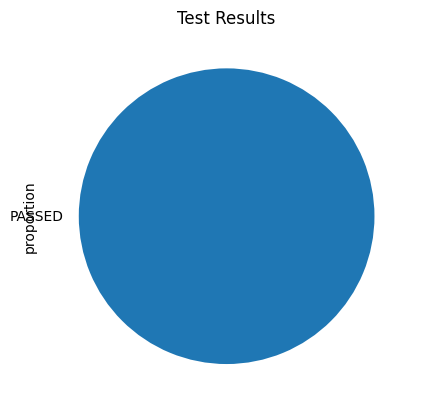

In [16]:
now = datetime.now()

outputPromptAI.to_csv(f"{MSG_TESTRESULT_FOLDER}\\test_promptai_{now.strftime('%Y%m%d%H%M%S')}.csv", mode='wb', index=False, quoting=csv.QUOTE_NONNUMERIC)


outputPromptAI.testresult_categoria_mail.value_counts(normalize=True).plot(kind='pie', title='Test Results')
row_count = len(outputPromptAI)
print(f"Number of tests: {row_count}")
outputPromptAI.testresult_categoria_mail.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

Test Data with Prompt and Embeddings (Parallel Processing)

In [11]:
promptai_testdata = msg_collection.copy(deep=True)
# WARNING: IT IS NOT POSSIBLE TO CALL MEMORY SEARCH WITH ASYNCIO, SO WE NEED TO GET THE EMBEDDINGS BEFOREHAND USING NEST_ASYNCIO AND ASYNCIO.GATHER
# iterate over the promptai_testadata and call the function get_embeddings with the row data. Take the result and put into a dictionary with the msgid as key and the result as value
async def generate_embedding(row): 
    result = await get_embeddings(row[1])
    return result

async def generate_embeddings():    
    print("Starting tasks") 
    promptai_testdata['embeddings'] = await tqdm_asyncio.gather(*(generate_embedding(v) for v in promptai_testdata.iterrows()))

start = time.time()
asyncio.run(generate_embeddings())
promptai_testdata.head()
end = time.time()
debug(f"Test Execution time: {(end-start) * 10**3} ms")

Starting tasks


 50%|█████     | 2/4 [00:01<00:00,  2.22it/s]

Execution time for <VI0PR83MB073893769A00EA779B6DF285E01B2@VI0PR83MB0738.EURPRD83.prod.outlook.com>: 913.5351181030273 ms
Execution time for <CAFbA+2v9_r2o86dA3bS94mkNe9sv56y3LTaG3xAi0e9zs3fDBw@mail.gmail.com>: 1024.9018669128418 ms
Execution time for <CAFbA+2t_3QLx3eKoYLGkDefoe6Y0GkuB8AhCwiWhq8bVVCOzeg@mail.gmail.com>: 1054.13818359375 ms


100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

Execution time for <CAFbA+2sdtxAOvfjofHXXs=L=+tZsAUQ3h9Q0QapZhEY4+Cbmnw@mail.gmail.com>: 1546.5936660766602 ms
Test Execution time: 1573.3435153961182 ms


In [12]:
def run_async_method(index, row):
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    result = loop.run_until_complete(process_row(index, row))
    loop.close()
    return result

async def process_row(index, row): 
    jsonresult = await get_correct_mail_with_embeddings_from_msg(row,row['embeddings'])
    jsonresult = json.loads(jsonresult.content)
    result = {
        'index': index,
        'result': jsonresult["mailToTestResult"],
        'testresult': "PASSED" if jsonresult["mailToTestResult"] == row['Categoria Email'] else "FAILED",
        'reasoning': jsonresult["reasoning"]
    }
    return result

# Get the number of CPUs
num_cpus = multiprocessing.cpu_count()
debug(f'"Executing on {num_cpus} CPUs"')
start = time.time()

with concurrent.futures.ThreadPoolExecutor(max_workers=num_cpus) as executor:
    futures = list(executor.map(lambda x: run_async_method(*x), tqdm(promptai_testdata.iterrows(), total=promptai_testdata.shape[0], desc="Processing msg data...")))
    for result in futures:        
        promptai_testdata.at[result['index'], 'result'] = result['result']
        promptai_testdata.at[result['index'], 'testresult'] = result['testresult']
        promptai_testdata.at[result['index'], 'reasoning'] = result['reasoning']
end = time.time()
debug(f"Test Execution time: {(end-start) * 10**3} ms")
outputPromptEmbeddings = pd.DataFrame(promptai_testdata, columns=["msgid", "filename", "expectedresult", "result", "testresult", "reasoning"])
outputPromptEmbeddings.head()

"Executing on 8 CPUs"


Processing msg data...:   0%|          | 0/4 [00:00<?, ?it/s]

Execution time for <CAFbA+2v9_r2o86dA3bS94mkNe9sv56y3LTaG3xAi0e9zs3fDBw@mail.gmail.com>: 743.222713470459 ms
Token consumption for <CAFbA+2v9_r2o86dA3bS94mkNe9sv56y3LTaG3xAi0e9zs3fDBw@mail.gmail.com> - PromptTokens: 582 CompletionTokens: 42
Execution time for <CAFbA+2sdtxAOvfjofHXXs=L=+tZsAUQ3h9Q0QapZhEY4+Cbmnw@mail.gmail.com>: 787.6749038696289 ms
Token consumption for <CAFbA+2sdtxAOvfjofHXXs=L=+tZsAUQ3h9Q0QapZhEY4+Cbmnw@mail.gmail.com> - PromptTokens: 578 CompletionTokens: 42
Execution time for <CAFbA+2t_3QLx3eKoYLGkDefoe6Y0GkuB8AhCwiWhq8bVVCOzeg@mail.gmail.com>: 970.6652164459229 ms
Token consumption for <CAFbA+2t_3QLx3eKoYLGkDefoe6Y0GkuB8AhCwiWhq8bVVCOzeg@mail.gmail.com> - PromptTokens: 537 CompletionTokens: 47
Execution time for <VI0PR83MB073893769A00EA779B6DF285E01B2@VI0PR83MB0738.EURPRD83.prod.outlook.com>: 1251.4054775238037 ms
Token consumption for <VI0PR83MB073893769A00EA779B6DF285E01B2@VI0PR83MB0738.EURPRD83.prod.outlook.com> - PromptTokens: 549 CompletionTokens: 41
Test Exe

,msgid,filename,expectedresult,result,testresult,reasoning
0,<VI0PR83MB073893769A00EA779B6DF285E01B2@VI0PR8...,RE_ Availability Confirmation for_ ENT _ Azure...,UNKNOWN,UNKNOWN,PASSED,Il contenuto della mail non fornisce informazi...
1,<CAFbA+2v9_r2o86dA3bS94mkNe9sv56y3LTaG3xAi0e9z...,_ESTERNO_ Patching sistemi operativi su vm win...,infrasupport@pippo.it,infrasupport@pippo.it,PASSED,Il titolo e il contenuto della mail fanno rife...
2,<CAFbA+2sdtxAOvfjofHXXs=L=+tZsAUQ3h9Q0QapZhEY4...,_ESTERNO_ Rallentamenti sull'applicazione PDP.msg,appsupport@pippo.it,appsupport@pippo.it,PASSED,Il titolo e il contenuto della mail fanno rife...
3,<CAFbA+2t_3QLx3eKoYLGkDefoe6Y0GkuB8AhCwiWhq8bV...,_ESTERNO_ Test messaggio mail dispatcher.msg,databasesupport@pippo.it,databasesupport@pippo.it,PASSED,Il risultato della ricerca vettoriale indica c...


Test Results (Prompt with Embeddings)

Number of tests: 4


testresult
PASSED    100.0%
Name: proportion, dtype: object

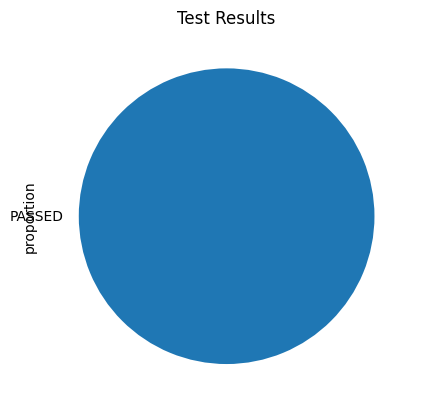

In [13]:
now = datetime.now()

outputPromptEmbeddings.to_csv(f"{MSG_TESTRESULT_FOLDER}\\test_embeddings_{now.strftime('%Y%m%d%H%M%S')}.csv", mode='wb', index=False, quoting=csv.QUOTE_NONNUMERIC)


outputPromptEmbeddings.testresult.value_counts(normalize=True).plot(kind='pie', title='Test Results')
row_count = len(outputPromptEmbeddings)
print(f"Number of tests: {row_count}")
outputPromptEmbeddings.testresult.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'